<a href="https://colab.research.google.com/github/nilaynishant/AIMLTutorial/blob/main/10_Prithvi_Foundation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install terratorch==0.99.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.0/849.0 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 33.7 MB/s eta 0:00:00
   ━

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.optim as optim

import terratorch
from terratorch.datamodules import Landslide4SenseNonGeoDataModule
from terratorch.datasets import Landslide4SenseNonGeo
from terratorch.tasks import SemanticSegmentationTask

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from huggingface_hub import snapshot_download

wxc_downscaling not installed
wxc_downscaling not installed


In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
  import gdown
  if not os.path.isfile('Landslide4sense.zip'):
    gdown.download("https://drive.google.com/uc?id=1Ds_7r4wgeejFM3-f2MdJWBYrPFzAt8-Z")
    !unzip Landslide4sense.zip
  local_path = '.'
else:
  local_path = snapshot_download(repo_id='ibm-nasa-geospatial/Landslide4sense', repo_type="dataset", cache_dir='.')

from huggingface_hub import hf_hub_download
hf_hub_download(repo_id='ibm-nasa-geospatial/Prithvi-EO-2.0-300M',  filename="config.json")

Downloading...
From (original): https://drive.google.com/uc?id=1Ds_7r4wgeejFM3-f2MdJWBYrPFzAt8-Z
From (redirected): https://drive.google.com/uc?id=1Ds_7r4wgeejFM3-f2MdJWBYrPFzAt8-Z&confirm=t&uuid=2e0ca0bb-73ad-41c7-9e07-5255b8268fd4
To: /content/Landslide4sense.zip
100%|██████████| 3.08G/3.08G [00:47<00:00, 64.7MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: annotations/validation/mask_185.h5  
  inflating: annotations/validation/mask_186.h5  
  inflating: annotations/validation/mask_187.h5  
  inflating: annotations/validation/mask_191.h5  
  inflating: annotations/validation/mask_189.h5  
  inflating: annotations/validation/mask_188.h5  
  inflating: annotations/validation/mask_190.h5  
  inflating: annotations/validation/mask_192.h5  
  inflating: annotations/validation/mask_193.h5  
  inflating: annotations/validation/mask_194.h5  
  inflating: annotations/validation/mask_19.h5  
  inflating: annotations/validation/mask_195.h5  
  inflating: annotations/validation/mask_198.h5  
  inflating: annotations/validation/mask_196.h5  
  inflating: annotations/validation/mask_197.h5  
  inflating: annotations/validation/mask_202.h5  
  inflating: annotations/validation/mask_2.h5  
  inflating: annotations/validation/mask_199.h5  
  inflating: annotations/validation/mask_201.h5  
  

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/753 [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/models--ibm-nasa-geospatial--Prithvi-EO-2.0-300M/snapshots/e4aabdc440c8ee703a749def8af5bf4700dee35b/config.json'

In [ ]:
local_path

'.'

In [ ]:
DATASET_PATH = local_path #os.path.join('dataset_dir', 'Landslide4sense')

In [ ]:
# those are the recommended transforms for this task
transforms = [
    albumentations.HorizontalFlip(),
    albumentations.Flip(),
    albumentations.Resize(224, 224),
    albumentations.pytorch.transforms.ToTensorV2(),
]

In [ ]:
# this datamodule allows access to the dataset in its various splits.
datamodule = Landslide4SenseNonGeoDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

In [ ]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds
len(datamodule.means)

14

In [ ]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

3799

In [ ]:
# checking datasets available bands
train_dataset.all_band_names

('COASTAL AEROSOL',
 'BLUE',
 'GREEN',
 'RED',
 'RED_EDGE_1',
 'RED_EDGE_2',
 'RED_EDGE_3',
 'NIR_BROAD',
 'WATER_VAPOR',
 'CIRRUS',
 'SWIR_1',
 'SWIR_2',
 'SLOPE',
 'DEM')

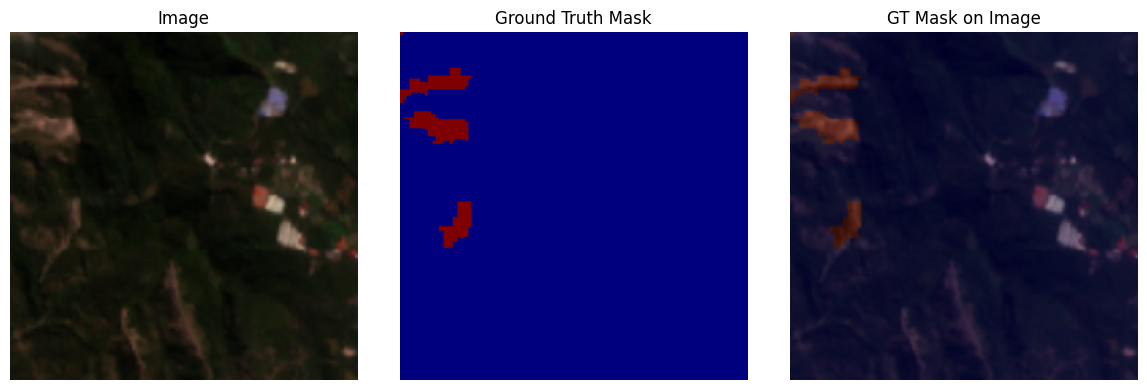

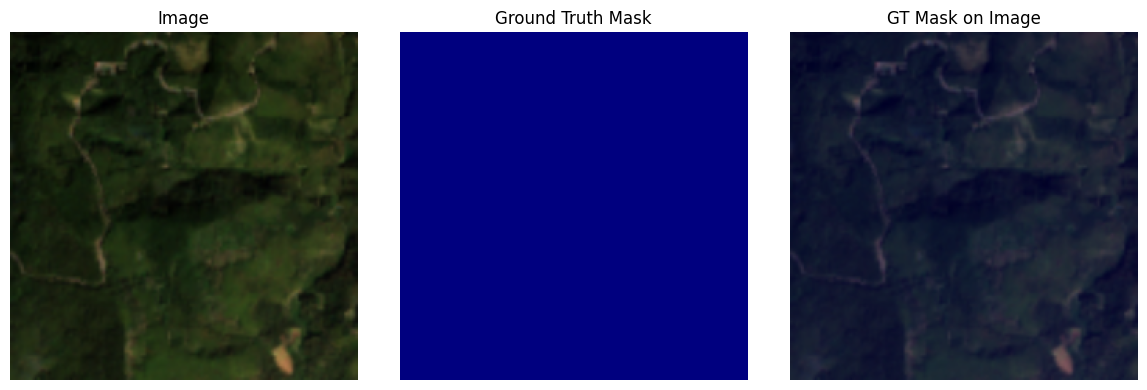

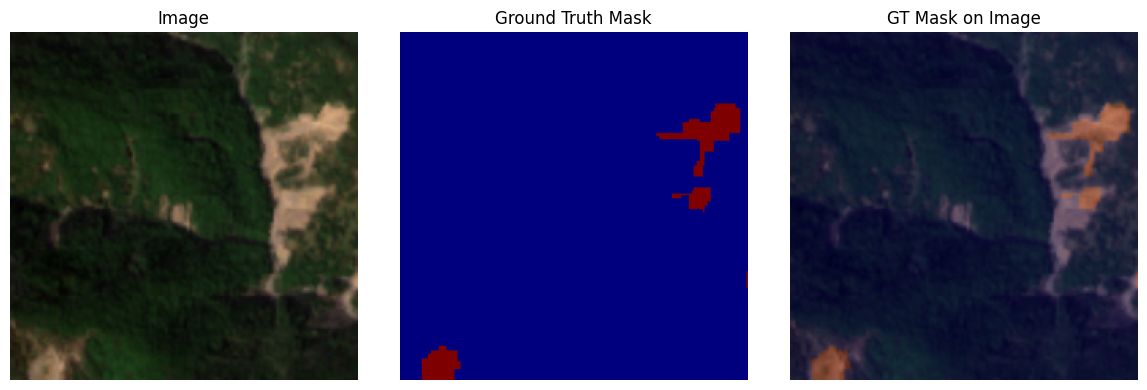

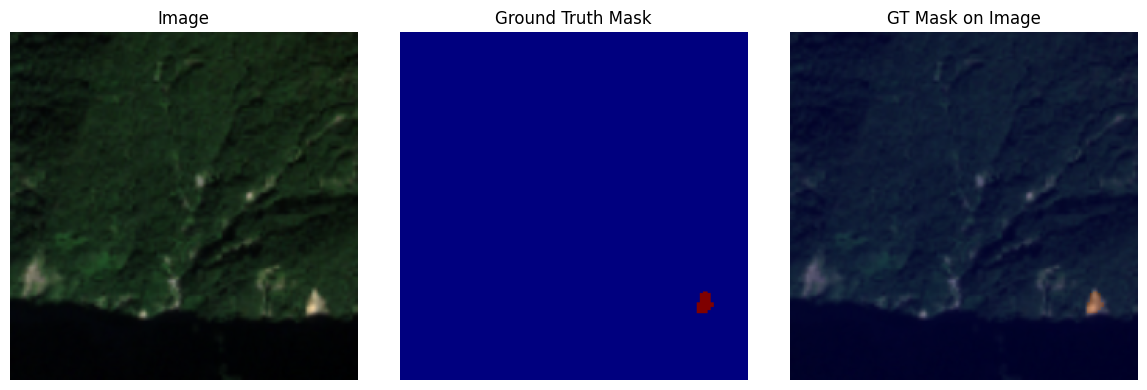

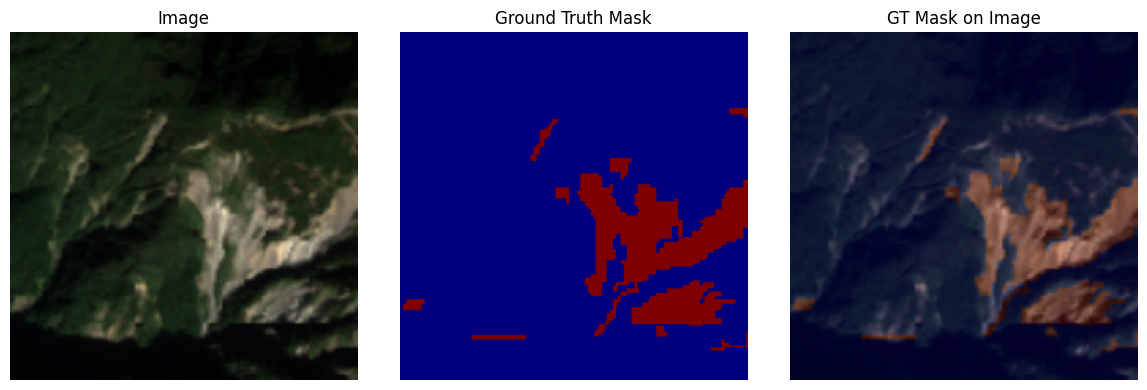

In [ ]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])


In [ ]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

245

In [ ]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

800

In [ ]:
pl.seed_everything(0)

# Logger
logger = TensorBoardLogger(
    save_dir="landslide4sense",
    name="tutorial"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

# colab will kill the kernel after ~24 epochs, therefore stopping after two and pull the correct checkpoint after
max_epochs = 1 if 'google.colab' in sys.modules else 50


checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",      # Directory to save the checkpoints
    filename="epoch-{epoch:02d}", # Filename format
    save_top_k=-1,               # Save all checkpoints
    every_n_epochs=50,            # Save every epoch
    save_on_train_epoch_end=True # Ensure saving after each epoch
)


# Trainer
trainer = pl.Trainer(
    accelerator=device,
    num_nodes=1,
    logger = logger,
    max_epochs=max_epochs,
    check_val_every_n_epoch=2,
    log_every_n_steps=50,
    enable_checkpointing=True,
    default_root_dir="root_dir",
    callbacks=[checkpoint_callback],
)

# DataModule
data_module = Landslide4SenseNonGeoDataModule(
    batch_size=8,
    bands = ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": True,
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 1,
        "num_classes": 2,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "head_channel_list": [128, 64],
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_vit_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_vit_600
            },
            {
                "name": "ReshapeTokensToImage"
            }
        ]
    },
    plot_on_val=False,
    loss="focal",
    lr=1.0e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.1},
    scheduler="StepLR",
    scheduler_hparams={"step_size": 10, "gamma": 0.9},
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Prithvi_EO_V2_300M.pt:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [ ]:
trainer.fit(model, datamodule=data_module)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | PixelWiseModel   | 319 M  | train
1 | criterion     | FocalLoss        | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | ModuleList       | 0      | train
-----------------------------------------------------------
319 M     Trainable params
0         Non-trainable params
319 M     Total params
1,277.348 Total estimated model params size (MB)
627       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | PixelWiseModel   | 319 M  | train
1 | crite

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# on colab 50 epochs would run into a timeout (approx. 23 are possible), therefore grabbing a checkpoint from epoch 50
if 'google.colab' in sys.modules:
  import gdown
  if not os.path.isfile('landslide4sense.ckpt.zip'):
    gdown.download("https://drive.google.com/uc?id=12lFg4N2ibc4g6Pz8CiX5cJQNTuUXcTmF")
    !unzip landslide4sense.ckpt.zip

Downloading...
From (original): https://drive.google.com/uc?id=12lFg4N2ibc4g6Pz8CiX5cJQNTuUXcTmF
From (redirected): https://drive.google.com/uc?id=12lFg4N2ibc4g6Pz8CiX5cJQNTuUXcTmF&confirm=t&uuid=3d217660-ead5-4055-912e-c77c348043b2
To: /content/landslide4sense.ckpt.zip
100%|██████████| 3.52G/3.52G [01:37<00:00, 36.3MB/s]


Archive:  landslide4sense.ckpt.zip
  inflating: landslide4sense.ckpt    


In [ ]:
trainer.test(model, datamodule=data_module, ckpt_path="./landslide4sense.ckpt")

INFO: Restoring states from the checkpoint path at ./landslide4sense.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./landslide4sense.ckpt
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/dccstor/terratorch/users/rkie/gitco/Prithvi-EO-2.0/examples/checkpoints' to '/content/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at ./landslide4sense.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./landslide4sense.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.9852952361106873          │
│      test/Multiclass_F1_Score       │         0.9852951765060425          │
│    test/Multiclass_Jaccard_Index    │         0.6587659120559692          │
│ test/Multiclass_Jaccard_Index_Micro │         0.9710166454315186          │
│              test/loss              │       1.8921706441688002e-06        │
│      test/multiclassaccuracy_0      │         0.9967918395996094          │
│      test/multiclassaccuracy_1      │         0.3877629339694977          │
│    test/multiclassjaccardindex_0    │          0.985186755657196          │
│    test/multiclassjaccardindex_1    │         0.3323451280593872          │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 1.8921706441688002e-06,
  'test/Multiclass_Accuracy': 0.9852952361106873,
  'test/multiclassaccuracy_0': 0.9967918395996094,
  'test/multiclassaccuracy_1': 0.3877629339694977,
  'test/Multiclass_F1_Score': 0.9852951765060425,
  'test/Multiclass_Jaccard_Index': 0.6587659120559692,
  'test/multiclassjaccardindex_0': 0.985186755657196,
  'test/multiclassjaccardindex_1': 0.3323451280593872,
  'test/Multiclass_Jaccard_Index_Micro': 0.9710166454315186}]

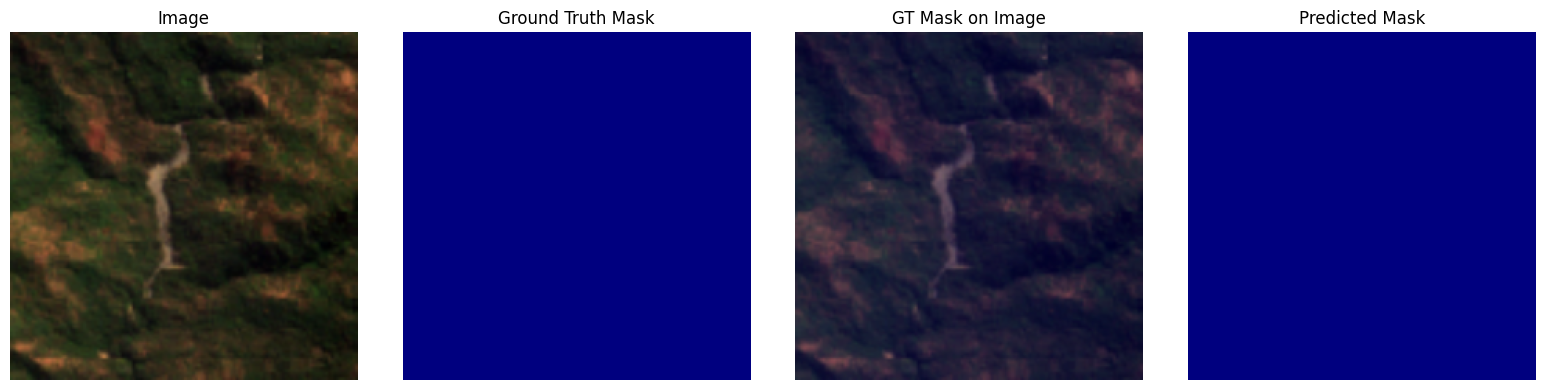

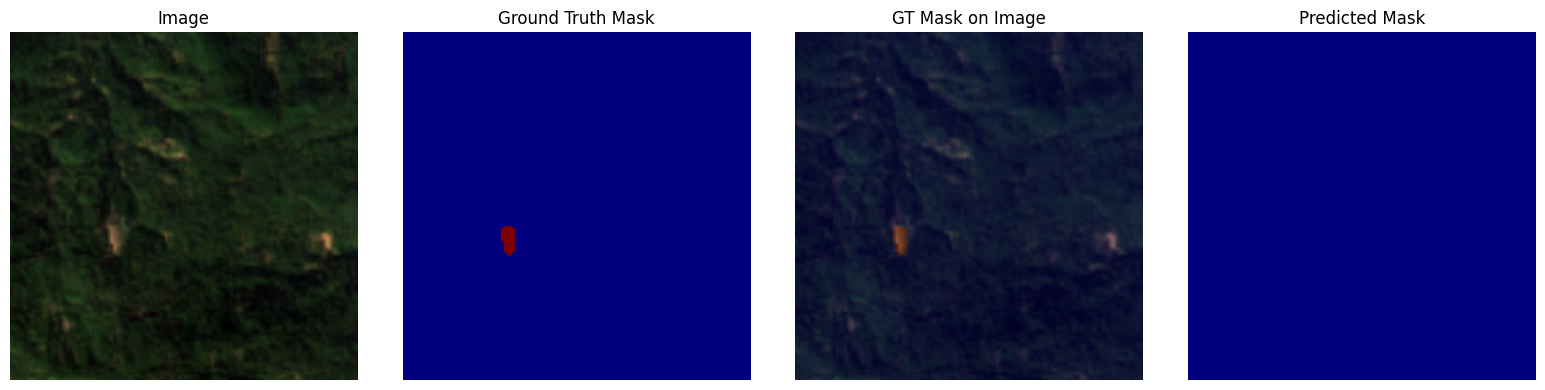

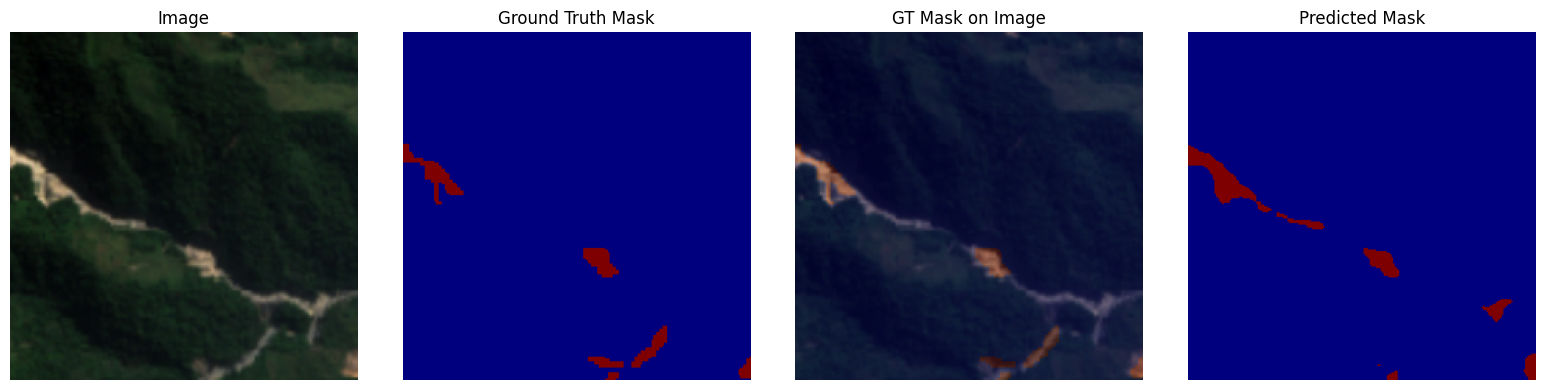

In [ ]:
# now we can use the model for predictions and ploting!
best_ckpt_path = "./landslide4sense.ckpt"
model = SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_args=model.hparams.model_args,
    model_factory=model.hparams.model_factory
)

test_dataset = data_module.test_dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = data_module.test_dataloader()
model.to(device)
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(device)
    masks = batch["mask"].to(device)
    other_keys = batch.keys() - {"image", "mask", "filename"}
    rest = {k: batch[k].to(device) for k in other_keys}

    outputs = model(images, **rest)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5,8):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[i]
    test_dataset.plot(sample)